In [17]:
# 데이터 전처리, 데이터 증강

import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

Files already downloaded and verified
Files already downloaded and verified


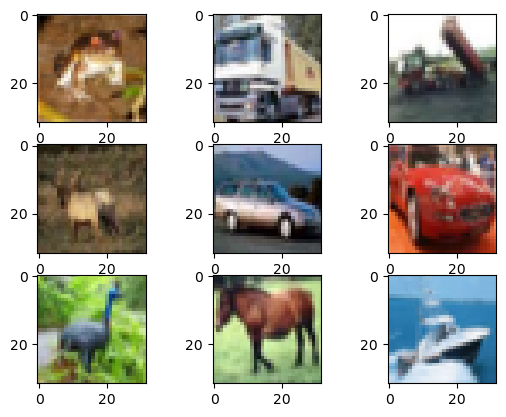

In [23]:
# 데이터셋 불러오기

training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = ToTensor(),
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = ToTensor(),
)
for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))       #  permute는 순서를 바꿔줌(C,H,W): 0,1,2 -->  (H,W,C): 1,2,0
plt.show()

Files already downloaded and verified
Files already downloaded and verified


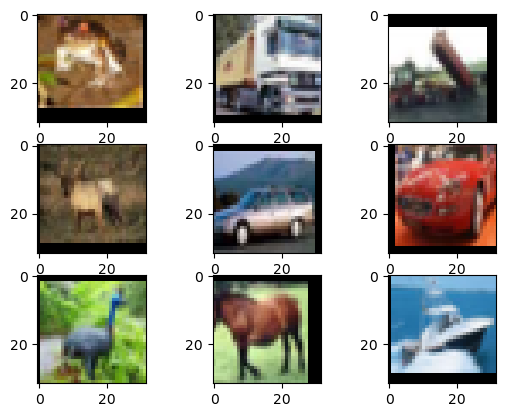

In [24]:
# 크롭핑과 뒤집기 추가 -=> 데이터 증강
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip,RandomCrop

transform = Compose([       # compose는 전처리하여 데이터를 가져옴
    T.ToTensor(),       #  이미지 데이터의 차원 순서가 [높이, 너비, 채널]에서 [채널, 높이, 너비]로 변경
    RandomCrop((32,32),padding = 4),        # 랜덤으로 이미지를 크롭하여 제거/ 패딩이 4  / RandomCrop 무작위로자르기 크롭
    RandomHorizontalFlip(p= 0.5)
])
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform,
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform,
)
for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))      
plt.show()

Files already downloaded and verified
Files already downloaded and verified


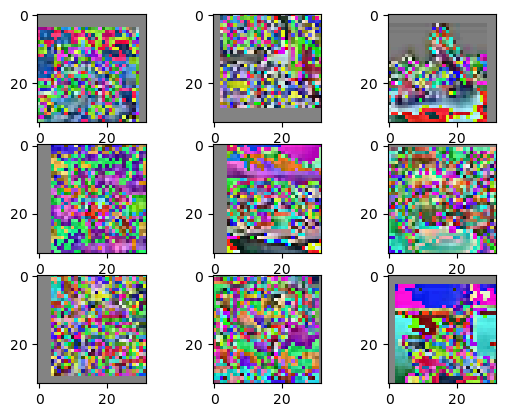

In [36]:
from torchvision.transforms import RandomHorizontalFlip,RandomCrop, Normalize

# 데이터 전처리에 정규화를 추가
transform = Compose([
    T.ToPILImage(),    
    RandomCrop( (32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5),(0.2,0.2,0.2)),
    T.ToPILImage(), 
])

training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform,
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform,
)

for i in range(9):
    # img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    # plt.imshow(img.permute(1,2,0))  #(C,H,W):0 1 2 -- 1 2 0   (H,W,C)
    plt.imshow(transform(training_dataset.data[i]))
plt.show() 

In [42]:
# 베이직 블럭
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, int_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(int_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        out = self.pool(x)
        return out

In [ ]:
import torch
class CNN(nn.Module):
    # 모델의 생성자(initializer) 함수. 모델의 구조와 계층을 정의
    def __init__(self, num_class):
        # 부모 클래스인 nn.Module의 생성자를 호출하여 모델을 초기화
        super(CNN,self).__init__()

         # === 특징 추출기 (Feature Extractor) ===
         # BasicBlock은 여러 계층(Conv, ReLU, Pool 등)을 묶어놓은 사용자 정의 블록
         # 주석은 (채널, 높이, 너비) 형태의 데이터 크기 변화
        self.block1 = BasicBlock(3,64,64)   # (3,32,32) (64,32,32) (64,32,32) (64,16,16)/ # 입력: (3,32,32) -> block1 통과 후 -> 출력: (64,16,16)
        self.block2 = BasicBlock(64,128,128)    # (64,16,16) (128,16,16) (128,16,16) (128,8,8)/ # 입력: (64,16,16) -> block2 통과 후 -> 출력: (128,8,8)

        # 분류기
        # block2를 통과한 (128, 8, 8) 크기의 3D 특징 맵(feature map)을 1D 벡터로 펼친 후,
        self.fc1 = nn.Linear(128*8*8,2048)      # 128*8*8 (8192)개의 입력 노드를 2048개로 압축
        self.fc2 = nn.Linear(2048,256)          # 2048개의 노드를 256개로 다시 압축
        self.fc3 = nn.Linear(256,num_class)     # 최종적으로 256개의 노드를 분류할 클래스의 개수
        self.relu = nn.ReLU ()    # 기울기 소실 방지
    # forward 함수는 데이터가 모델을 통과하는 순서와 과정을 정의
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        # (-1,128*8*8)
        x = torch.flatten(x,start_dim=1) # strat_dim = 어느차수부터 필것인지 지정/ flatten은 view처럼 펼쳐주는 기능
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [44]:
# 샘플데이터를 생성해서 구조 확인
X = torch.randn(4,3,32,32)
model = CNN(10)
model(X)

tensor([[-0.0367,  0.0171,  0.0535,  0.0376, -0.0278, -0.0390, -0.0361,  0.0196,
         -0.0092, -0.0214],
        [-0.0386,  0.0182,  0.0531,  0.0378, -0.0300, -0.0355, -0.0398,  0.0223,
         -0.0116, -0.0218],
        [-0.0408,  0.0147,  0.0531,  0.0353, -0.0302, -0.0384, -0.0352,  0.0209,
         -0.0107, -0.0208],
        [-0.0382,  0.0169,  0.0516,  0.0374, -0.0273, -0.0386, -0.0356,  0.0211,
         -0.0099, -0.0209]], grad_fn=<AddmmBackward0>)

In [ ]:
# 데이터 증강
# 데이터 셋
# 데이터 로더
# 학습루프
# 평가
# 예측

In [60]:
%pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [61]:
from torchsummary import summary
model = CNN(10)
summary(model,(3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicBlock: 1-1                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
├─BasicBlock: 1-2                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
├─Linear: 1-3                            [-1, 2048]                16

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicBlock: 1-1                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
├─BasicBlock: 1-2                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
├─Linear: 1-3                            [-1, 2048]                16

In [65]:
for name, param in model.named_parameters():
    print(f'{name} {list(param.shape)}')

block1.conv1.weight [64, 3, 3, 3]
block1.conv1.bias [64]
block1.conv2.weight [64, 64, 3, 3]
block1.conv2.bias [64]
block2.conv1.weight [128, 64, 3, 3]
block2.conv1.bias [128]
block2.conv2.weight [128, 128, 3, 3]
block2.conv2.bias [128]
fc1.weight [2048, 8192]
fc1.bias [2048]
fc2.weight [256, 2048]
fc2.bias [256]
fc3.weight [10, 256]
fc3.bias [10]


In [69]:
model

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [70]:
model.fc3       # 인덱스처럼 model. 뒤에 붙이면 정보를 볼 수 있음

# model.fc3  = nn.Linear(in_features=256, out_features=2, bias=True) # 레이어에 접근 가능하며 변경도 가능하다

Linear(in_features=256, out_features=10, bias=True)

In [75]:
from tqdm import tqdm

# 데이터 증강
transform = Compose([  
    RandomCrop( (32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5),(0.2,0.2,0.2)),
])

# 데이터 셋

training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform,
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform,
)

from torch.utils.data.dataloader import DataLoader
# 데이터 로더
train_loader = DataLoader(training_dataset, batch_size =256 , shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(10)
model.to(device)

from torch.optim import Adam
lr = 1e-3
optim = Adam(model.parameters(), lr =lr)
epochs = 1
# 학습루프
for epoch in range(epochs):
    for data, label in tqdm(train_loader,desc = f'epoch: {epoch+1}'):
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    if (epoch+1) % 10 == 0 :
        print (f'epoch : {epoch+1} loss : {loss.item()}')
        
torch.save(model.state_dict(), 'cifar.pth')


Files already downloaded and verified
Files already downloaded and verified


epoch: 1: 100%|██████████| 196/196 [10:54<00:00,  3.34s/it]


epoch : 1 loss : 1.568650722503662


In [80]:
# 평가
model.load_state_dict(torch.load('cifar.pth',map_location=device,weights_only=True))

# 예측
num_corr = 0
with torch.no_grad():
    for data, label in test_loader :
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    print(f'Accurarcy : {num_corr/len(test_dataset)}')

Accurarcy : 0.4878
